# Modelo de transformador para compreensão da linguagem

bookmark_border

Executar no Google Colab
Ver fonte no GitHub
Baixar caderno
Este tutorial treina um modelo Transformer para traduzir um conjunto de dados de português para inglês . Este é um exemplo avançado que pressupõe conhecimento de geração de texto e atenção .

A ideia central por trás do modelo Transformer é a autoatenção — a capacidade de atender a diferentes posições da sequência de entrada para calcular uma representação dessa sequência. O Transformer cria pilhas de camadas de autoatenção e é explicado abaixo nas seções Atenção ao produto escalado e Atenção multi-cabeças .

Um modelo de transformador lida com entradas de tamanho variável usando pilhas de camadas de autoatenção em vez de RNNs ou CNNs . Essa arquitetura geral tem várias vantagens:

Ele não faz suposições sobre as relações temporais/espaciais entre os dados. Isso é ideal para processar um conjunto de objetos (por exemplo, unidades de StarCraft ).
As saídas de camada podem ser calculadas em paralelo, em vez de uma série como um RNN.
Itens distantes podem afetar a saída uns dos outros sem passar por muitas etapas RNN ou camadas de convolução (consulte Transformador de memória de cena , por exemplo).
Ele pode aprender dependências de longo alcance. Este é um desafio em muitas tarefas de sequência.
As desvantagens desta arquitetura são:

Para uma série temporal, a saída para um passo de tempo é calculada a partir de todo o histórico em vez de apenas as entradas e o estado oculto atual. Isso pode ser menos eficiente.
Se a entrada tiver uma relação temporal/espacial, como texto, alguma codificação posicional deve ser adicionada ou o modelo verá efetivamente um pacote de palavras.
Após treinar o modelo neste caderno, você poderá inserir uma frase em português e devolver a tradução em inglês.

## Configurar

In [1]:
!pip install tensorflow_datasets
!pip install -U tensorflow-text

In [2]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

In [3]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

## Baixe o conjunto de dados
Use os conjuntos de dados do TensorFlow para carregar o conjunto de dados de tradução português-inglês do projeto de tradução aberta TED Talks .

Este conjunto de dados contém aproximadamente 50.000 exemplos de treinamento, 1.100 exemplos de validação e 2.000 exemplos de teste.

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.ZEZK3W_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.ZEZK3W_1.0.0/ted_hrlr_translate-val…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.ZEZK3W_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


O objeto tf.data.Dataset retornado pelos conjuntos de dados do TensorFlow gera pares de exemplos de texto:



In [5]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


## Tokenização e destokenização de texto
Você não pode treinar um modelo diretamente no texto. O texto precisa ser convertido em alguma representação numérica primeiro. Normalmente, você converte o texto em sequências de IDs de token, que são usados ​​como índices em uma incorporação.

Uma implementação popular é demonstrada no tutorial do Tokenizer Subword cria tokenizers de subpalavra ( text.BertTokenizer ) otimizados para este conjunto de dados e os exporta em um saved_model .

Baixe e descompacte e importe o saved_model :

In [6]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 ━━━━━━━━━━━━━━━━━━━━ 1s 3us/step


'./ted_hrlr_translate_pt_en_converter_extracted'

In [8]:
tokenizers = tf.saved_model.load(model_name)

O tf.saved_model contém dois tokenizers de texto, um para inglês e outro para português. Ambos têm os mesmos métodos:



In [9]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

O método tokenize converte um lote de strings em um lote preenchido de IDs de token. Este método divide pontuação, letras minúsculas e normaliza unicode a entrada antes da tokenização. Essa padronização não é visível aqui porque os dados de entrada já estão padronizados.

In [10]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [11]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


O método detokenize tenta converter esses IDs de token de volta em texto legível por humanos:

In [12]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


O método de lookup de nível inferior converte de token-IDs em texto de token:



In [13]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

Aqui você pode ver o aspecto de "subpalavra" dos tokenizers. A palavra "searchability" é decomposta em "search ##ability" e a palavra "serendipity" em "s ##ere ##nd ##ip ##ity"



## Configurar pipeline de entrada
Para criar um pipeline de entrada adequado para treinamento, você aplicará algumas transformações ao conjunto de dados.

Esta função será usada para codificar os lotes de texto bruto:

In [14]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

Aqui está um pipeline de entrada simples que processa, embaralha e agrupa os dados:



In [15]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [16]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

## Codificação posicional
As camadas de atenção veem sua entrada como um conjunto de vetores, sem ordem sequencial. Este modelo também não contém nenhuma camada recorrente ou convolucional. Por causa disso, uma "codificação posicional" é adicionada para fornecer ao modelo algumas informações sobre a posição relativa dos tokens na sentença.

O vetor de codificação posicional é adicionado ao vetor de incorporação. Embeddings representam um token em um espaço d-dimensional onde tokens com significado semelhante estarão mais próximos uns dos outros. Mas os embeddings não codificam a posição relativa dos tokens em uma frase. Assim, após adicionar a codificação posicional, os tokens ficarão mais próximos uns dos outros com base na similaridade de seu significado e sua posição na sentença , no espaço d-dimensional.

A fórmula para calcular a codificação posicional é a seguinte:





In [17]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [18]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


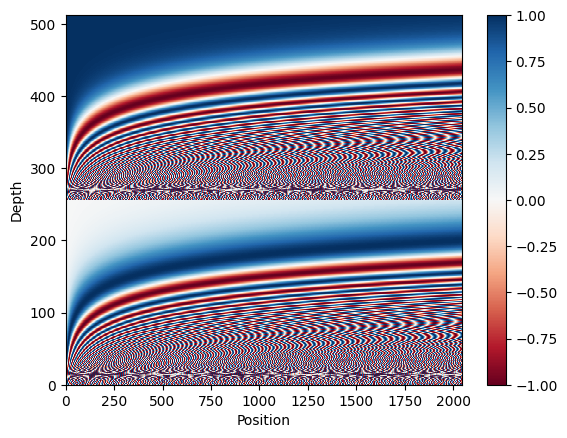

In [19]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Mascaramento
Mascare todos os tokens de bloco no lote de sequência. Ele garante que o modelo não trate o preenchimento como entrada. A máscara indica onde o valor de pad 0 está presente: ela emite um 1 nesses locais e um 0 caso contrário.

In [20]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [21]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

A máscara de antecipação é usada para mascarar os tokens futuros em uma sequência. Em outras palavras, a máscara indica quais entradas não devem ser usadas.

Isso significa que para prever o terceiro token, apenas o primeiro e o segundo token serão usados. Da mesma forma para prever o quarto token, apenas o primeiro, segundo e terceiro tokens serão usados ​​e assim por diante.

In [22]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [23]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Atenção ao produto escalado
scaled_dot_product_attention

A função de atenção utilizada pelo transformador tem três entradas: Q (consulta), K (chave), V (valor). A equação usada para calcular os pesos de atenção é:


A atenção do produto escalar é dimensionada por um fator de raiz quadrada da profundidade. Isso é feito porque para grandes valores de profundidade, o produto escalar cresce em magnitude empurrando a função softmax onde tem pequenos gradientes resultando em um softmax muito difícil.

Por exemplo, considere que Q e K têm média 0 e variância 1. A multiplicação de suas matrizes terá média 0 e variância dk . Portanto, a raiz quadrada de dk é usada para dimensionamento, para que você obtenha uma variação consistente, independentemente do valor de dk . Se a variação for muito baixa, a saída pode ser muito plana para otimizar efetivamente. Se a variação for muito alta, o softmax pode saturar na inicialização, dificultando o aprendizado.

A máscara é multiplicada por -1e9 (próximo ao infinito negativo). Isso é feito porque a máscara é somada com a multiplicação da matriz escalonada de Q e K e é aplicada imediatamente antes de um softmax. O objetivo é zerar essas células, e grandes entradas negativas para softmax são próximas de zero na saída.

In [24]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

Como a normalização softmax é feita em K, seus valores decidem a importância dada a Q.

A saída representa a multiplicação dos pesos de atenção e o vetor V (valor). Isso garante que os tokens nos quais você deseja se concentrar sejam mantidos como estão e os tokens irrelevantes serão eliminados.

In [25]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [26]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [27]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [28]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [29]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [30]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Atenção de várias cabeças

A atenção de várias cabeças consiste em quatro partes:

Camadas lineares.
Atenção de produto escalar escalado.
Camada linear final.
Cada bloco de atenção de várias cabeças recebe três entradas; Q (consulta), K (chave), V (valor). Estes são colocados através de camadas lineares (Densa) antes da função de atenção multi-cabeça.

No diagrama acima (K,Q,V) são passados ​​por camadas separadas lineares ( Dense ) para cada cabeça de atenção. Por simplicidade/eficiência, o código abaixo implementa isso usando uma única camada densa com num_heads vezes mais saídas. A saída é reorganizada para uma forma de (batch, num_heads, ...) antes de aplicar a função de atenção.

A função scaled_dot_product_attention definida acima é aplicada em uma única chamada, transmitida para eficiência. Uma máscara apropriada deve ser usada na etapa de atenção. A saída de atenção para cada cabeça é então concatenada (usando tf.transpose e tf.reshape ) e passa por uma camada Dense final.

Em vez de uma única cabeça de atenção, Q, K e V são divididos em várias cabeças porque permite que o modelo atenda conjuntamente a informações de diferentes subespaços de representação em diferentes posições. Após a divisão, cada cabeça tem uma dimensionalidade reduzida, de modo que o custo total de computação é o mesmo que uma atenção de cabeça única com dimensionalidade total.

In [31]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

Crie uma camada MultiHeadAttention para experimentar. Em cada local na sequência, y , o MultiHeadAttention executa todas as 8 cabeças de atenção em todos os outros locais da sequência, retornando um novo vetor de mesmo comprimento em cada local.

In [32]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Rede de feed forward pontual
A rede de feed forward pontual consiste em duas camadas totalmente conectadas com uma ativação ReLU entre elas.

In [33]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [34]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Codificador e decodificador

O modelo de transformador segue o mesmo padrão geral de um modelo de sequência a sequência padrão com atenção .

A sentença de entrada é passada por N camadas de codificador que geram uma saída para cada token na sequência.
O decodificador atende a saída do codificador e sua própria entrada (autoatenção) para prever a próxima palavra.
Camada do codificador
Cada camada do codificador consiste em subcamadas:

Atenção multi-cabeça (com máscara de preenchimento)
Redes de feed forward pontuais.
Cada uma dessas subcamadas tem uma conexão residual ao seu redor seguida por uma normalização de camada. As conexões residuais ajudam a evitar o problema do gradiente de fuga em redes profundas.

A saída de cada subcamada é LayerNorm(x + Sublayer(x)) . A normalização é feita no eixo d_model (último). Existem N camadas de codificador no transformador.

In [35]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, mask, training): # Changed the order of arguments

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [36]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

# Pass 'training' as a keyword argument
sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), training=False, mask=None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

## Camada do decodificador
Cada camada do decodificador consiste em subcamadas:

Atenção de várias cabeças mascaradas (com máscara de antecipação e máscara de preenchimento)
Atenção multi-cabeça (com máscara de preenchimento). V (valor) e K (chave) recebem a saída do encoder como entradas. Q (consulta) recebe a saída da subcamada de atenção multi-cabeças mascarada.
Redes de feed forward pontuais
Cada uma dessas subcamadas tem uma conexão residual ao seu redor seguida por uma normalização de camada. A saída de cada subcamada é LayerNorm(x + Sublayer(x)) . A normalização é feita no eixo d_model (último).

Existem N camadas de descodificadores no transformador.

Como Q recebe a saída do primeiro bloco de atenção do decodificador e K recebe a saída do codificador, os pesos de atenção representam a importância dada à entrada do decodificador com base na saída do codificador. Em outras palavras, o decodificador prevê o próximo token observando a saída do codificador e atendendo automaticamente sua própria saída. Veja a demonstração acima na seção de atenção ao produto escalado.

In [37]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [38]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

# Pass 'training' as a keyword argument
sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    training=False, look_ahead_mask=None, padding_mask=None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [39]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      # Pass 'training' as a keyword argument
      x = self.enc_layers[i](x, mask=mask, training=training)

    return x  # (batch_size, input_seq_len, d_model)

## Codificador
O Encoder é composto por:

Incorporação de entrada
Codificação posicional
N camadas do codificador
A entrada é colocada por meio de uma incorporação que é somada à codificação posicional. A saída desta soma é a entrada para as camadas do codificador. A saída do codificador é a entrada para o decodificador.

In [40]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


## Decodificador
O Decoder é composto por:

Incorporação de saída
Codificação posicional
N camadas do decodificador
O destino é colocado por meio de uma incorporação que é somada à codificação posicional. A saída desta soma é a entrada para as camadas do decodificador. A saída do decodificador é a entrada para a camada linear final.

In [41]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
            # Pass 'training' as a keyword argument
            x, block1, block2 = self.dec_layers[i](x, enc_output, training=training, # Changed here
                                                 look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [42]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Crie o transformador
O transformador consiste no codificador, decodificador e uma camada linear final. A saída do decodificador é a entrada para a camada linear e sua saída é retornada.

In [82]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training=False): # training is now a keyword argument
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

    # Pass 'training' as a keyword argument to the encoder
    enc_output = self.encoder(inp, mask=enc_padding_mask, training=training)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    # training is now passed as a keyword argument
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights


  def train_step(self, data): # Modified here to overwrite the train_step
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        inp, tar = data
        tar_inp = tar[:, :-1]
        tar_real = tar[:, 1:]

        with tf.GradientTape() as tape:
            predictions, _ = self(
                [inp, tar_inp], training=True
            )  # Forward pass
            loss = loss_function(tar_real, predictions)  # Loss calculation

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        train_loss(loss)
        train_accuracy(accuracy_function(tar_real, predictions))
        return {"loss": loss, "accuracy": accuracy_function(tar_real, predictions)} # added return value for train_step


  def create_masks(self, inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [44]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Definir hiperparâmetros
Para manter este exemplo pequeno e relativamente rápido, os valores para num_layers, d_model, dff foram reduzidos.

O modelo base descrito no artigo utilizado: num_layers=6, d_model=512, dff=2048 .

In [45]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Otimizador
Use o otimizador Adam com um agendador de taxa de aprendizado personalizado de acordo com a fórmula do artigo .




In [46]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000): # Changed from _init_ to __init__
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step): # Changed from _call_ to __call__
    # Cast step to tf.float32
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [47]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [48]:
temp_learning_rate_schedule = CustomSchedule(d_model)

# plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
# plt.ylabel("Learning Rate")
# plt.xlabel("Train Step")

In [49]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

## Perda e métricas
Como as sequências alvo são preenchidas, é importante aplicar uma máscara de preenchimento ao calcular a perda.

In [50]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [51]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Treinamento e checkpoint

In [52]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

Crie o caminho do ponto de verificação e o gerenciador de ponto de verificação. Isso será usado para salvar pontos de verificação a cada n épocas.

In [53]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

O destino é dividido em tar_inp e tar_real. tar_inp é passado como entrada para o decodificador. tar_real é a mesma entrada deslocada em 1: Em cada local em tar_input , tar_real contém o próximo token que deve ser previsto.

Por exemplo, sentence = "SOS Um leão na selva está dormindo EOS"

tar_inp = "SOS Um leão na selva está dormindo"

tar_real = "Um leão na selva está dormindo EOS"

O transformador é um modelo auto-regressivo: ele faz previsões uma parte de cada vez e usa sua saída até o momento para decidir o que fazer em seguida.

Durante o treinamento, este exemplo usa forçar o professor (como no tutorial de geração de texto ). O forçamento do professor é passar a saída real para a próxima etapa de tempo, independentemente do que o modelo prevê na etapa de tempo atual.

À medida que o transformador prevê cada token, a autoatenção permite que ele examine os tokens anteriores na sequência de entrada para prever melhor o próximo token.

Para evitar que o modelo espie a saída esperada, o modelo usa uma máscara de antecipação.

In [90]:
EPOCHS = 15

In [91]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

O português é usado como idioma de entrada e o inglês é o idioma de destino.



In [92]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_state()
  train_accuracy.reset_state()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 5.2500 Accuracy 0.2033
Epoch 1 Batch 50 Loss 5.2076 Accuracy 0.2179
Epoch 1 Batch 100 Loss 5.1804 Accuracy 0.2204
Epoch 1 Batch 150 Loss 5.1508 Accuracy 0.2233
Epoch 1 Batch 200 Loss 5.1186 Accuracy 0.2266
Epoch 1 Batch 250 Loss 5.0923 Accuracy 0.2295
Epoch 1 Batch 300 Loss 5.0681 Accuracy 0.2317
Epoch 1 Batch 350 Loss 5.0406 Accuracy 0.2341
Epoch 1 Batch 400 Loss 5.0171 Accuracy 0.2362
Epoch 1 Batch 450 Loss 4.9939 Accuracy 0.2387
Epoch 1 Batch 500 Loss 4.9762 Accuracy 0.2403
Epoch 1 Batch 550 Loss 4.9555 Accuracy 0.2419
Epoch 1 Batch 600 Loss 4.9373 Accuracy 0.2435
Epoch 1 Batch 650 Loss 4.9187 Accuracy 0.2452
Epoch 1 Batch 700 Loss 4.9016 Accuracy 0.2467
Epoch 1 Batch 750 Loss 4.8856 Accuracy 0.2479
Epoch 1 Batch 800 Loss 4.8720 Accuracy 0.2490
Epoch 1 Loss 4.8690 Accuracy 0.2492
Time taken for 1 epoch: 118.91 secs

Epoch 2 Batch 0 Loss 4.5421 Accuracy 0.2723
Epoch 2 Batch 50 Loss 4.5673 Accuracy 0.2724
Epoch 2 Batch 100 Loss 4.5707 Accuracy 0.2719
Epoch 2 Batch

## Executar inferência
As etapas a seguir são usadas para inferência:

Codifique a frase de entrada usando o tokenizer português ( tokenizers.pt ). Esta é a entrada do codificador.
A entrada do decodificador é inicializada com o token [START] .
Calcule as máscaras de preenchimento e as máscaras de antecipação.
O decoder então emite as previsões observando a encoder output e sua própria saída (autoatenção).
Concatene o token previsto para a entrada do decodificador e passe-o para o decodificador.
Nesta abordagem, o decodificador prevê o próximo token com base nos tokens anteriores que ele previu.

In [93]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, training=False, max_length=20):
    # input sentence is portuguese, hence adding the start and end token
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # as the target is english, the first token to the transformer should be the
    # english start token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = tokenizers.en.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

Crie uma instância dessa classe Translator e experimente-a algumas vezes:



In [94]:
translator = Translator(tokenizers, transformer)

In [95]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [96]:
sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


In [97]:
sentence = "os meus vizinhos ouviram sobre esta ideia."
ground_truth = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


In [98]:
sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to share with you a few stories of some magic stories that happened .
Ground truth   : so i 'll just share with you some stories very quickly of some magical things that have happened .


## Parcelas de atenção
A classe Translator retorna um dicionário de mapas de atenção que você pode usar para visualizar o funcionamento interno do modelo:



In [112]:
sentence = "eu gosto de jogar blackjack postando nos stories."
ground_truth = "I like to play blackjack posting on stories."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : eu gosto de jogar blackjack postando nos stories.
Prediction     : i like to play blackling on the editor to take us out of the sieria .
Ground truth   : I like to play blackjack posting on stories.


In [100]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [101]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

In [102]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

In [103]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

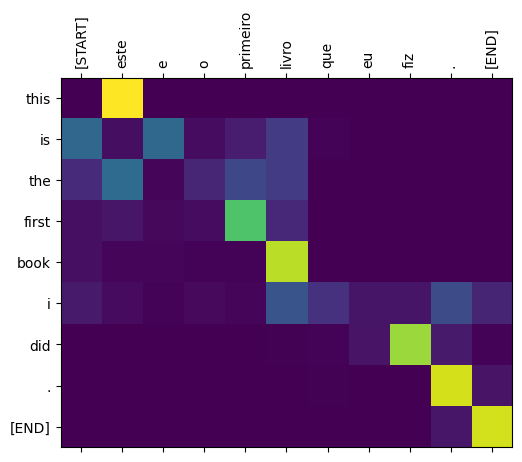

In [104]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [105]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

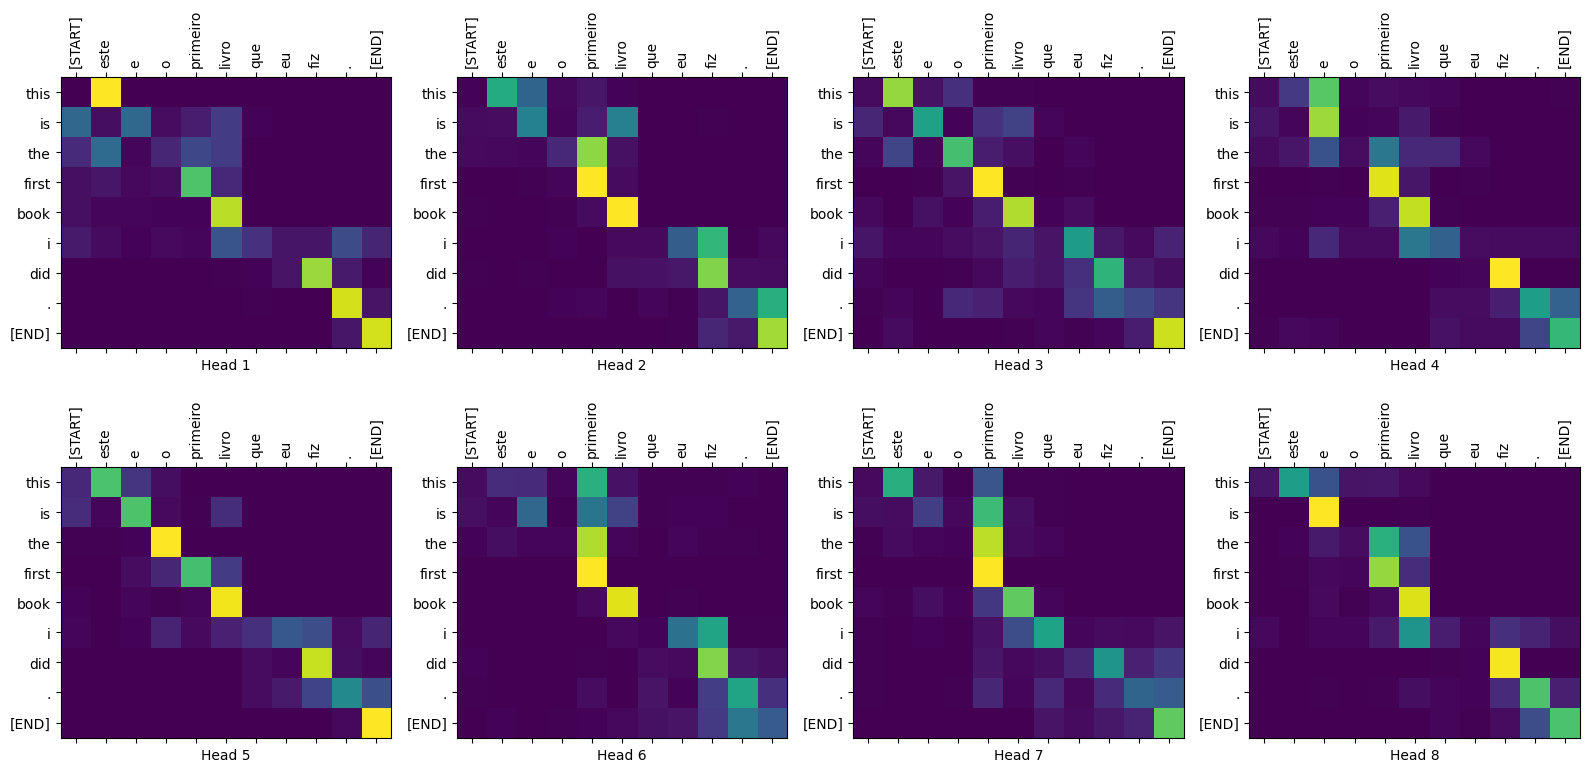

In [106]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

O modelo se sai bem em palavras desconhecidas. Nem "triceratops" ou "enciclopédia" estão no conjunto de dados de entrada e o modelo quase aprende a transliterá-los, mesmo sem um vocabulário compartilhado:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about triopsysopolis on enclolood .
Ground truth   : I read about triceratops in the encyclopedia.


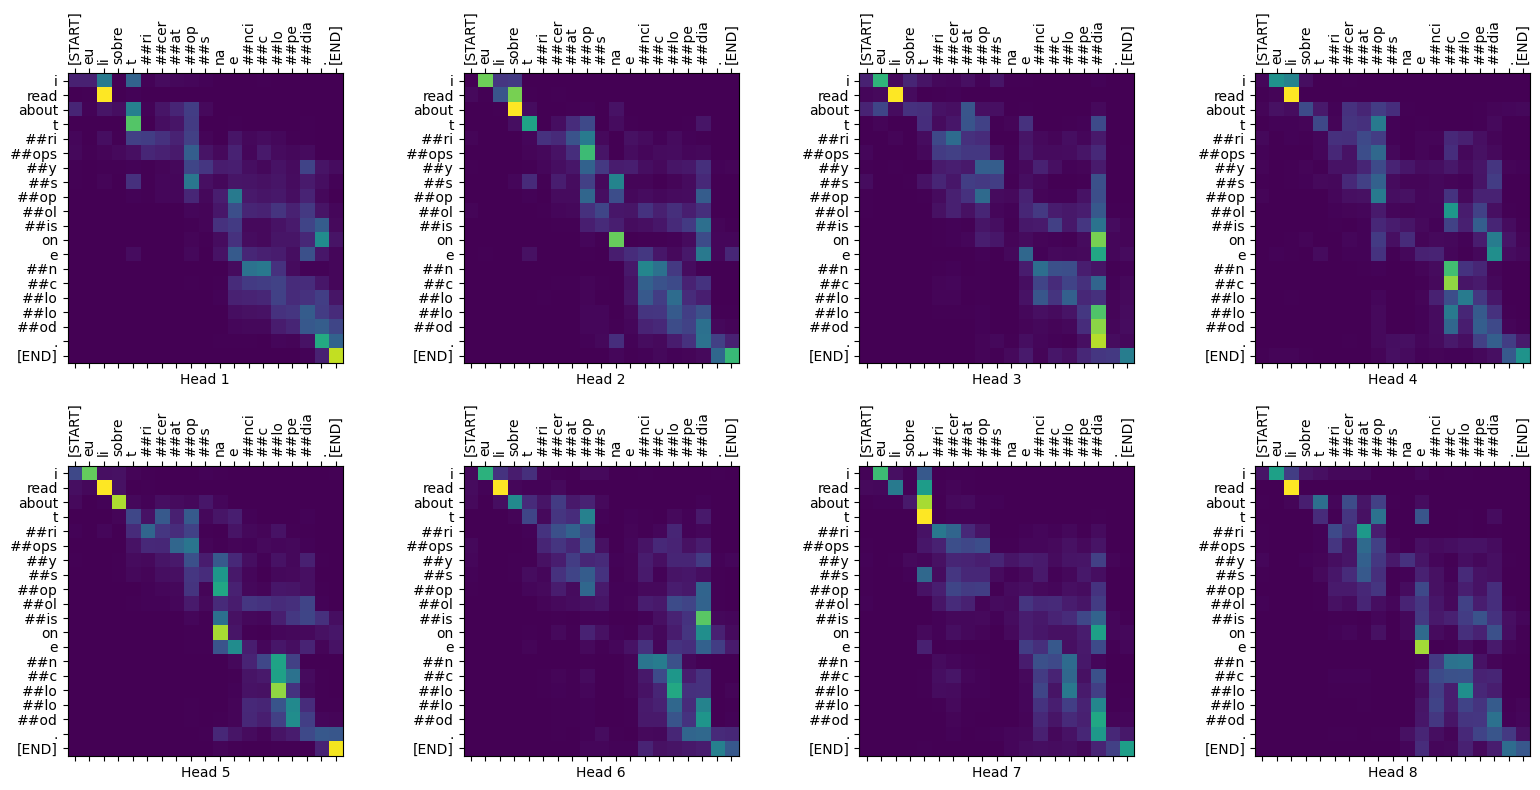

In [107]:
sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])